# Recurrent MGD
- please first see the `mgd_intro_jax` tutorial in this same directory.

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import copy

import src.utils.helper_functions as hf
import src.utils.rnn_functions as sf
import src.data_loader as dat

### Loading Some Temporal Data

In [ ]:
data     = dat.get_data("ECG")
U_train  = data["U_train"]
y0_train = data["y0_train"]
U_test   = data["U_test"]
y0_test  = data["y0_test"]

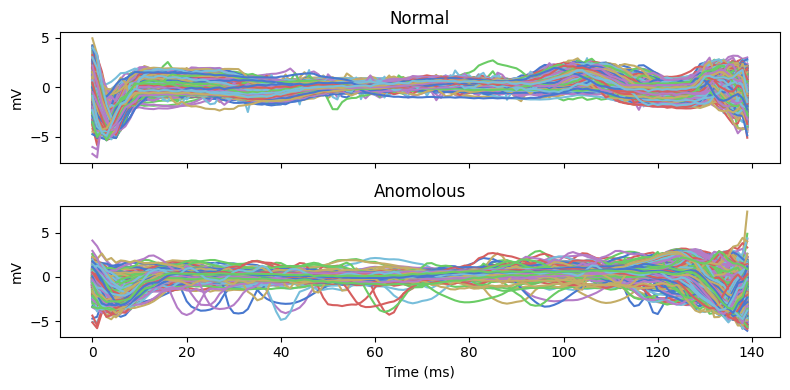

In [ ]:
plt.style.use('seaborn-v0_8-muted')
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
fig,ax = plt.subplots(2,1,figsize=(8,4),sharex=True)
ax[0].plot(U_train[y0_train==1].T)
ax[1].plot(U_train[y0_train==0].T)
ax[0].set_title("Normal")
ax[1].set_title("Anomolous")
ax[1].set_xlabel("Time (ms)")
ax[0].set_ylabel("mV")
ax[1].set_ylabel("mV")
plt.tight_layout()
plt.show()

### Initializing a State-Space Model

In [ ]:
from src.models import StateSpaceModel as SSM

model = SSM(
    N=32,
    train_params=["A","B","readout"],
    eta0="norm",
    epsilon=0.000001,
    tau_theta=64,
    readout_dims=[32,32,1],
    loss_func='CE'
    )

hf.print_tree_shapes(model.theta)

Discretized HiPPO matrices for 140 time steps


### Defining a Forward Euler Simulation
- According to SSM dynamics

In [ ]:
@jax.jit
def scan_ssm_batched_nomap(A, B, u, x0):
    def step(x, u_t):
        x_new = jnp.dot(x, A.T) + jnp.expand_dims(u_t, -1) * B 
        return x_new, x_new
    x_final, _ = jax.lax.scan(step, x0, u)
    return x_final 

### Examening a Batch of Output Data

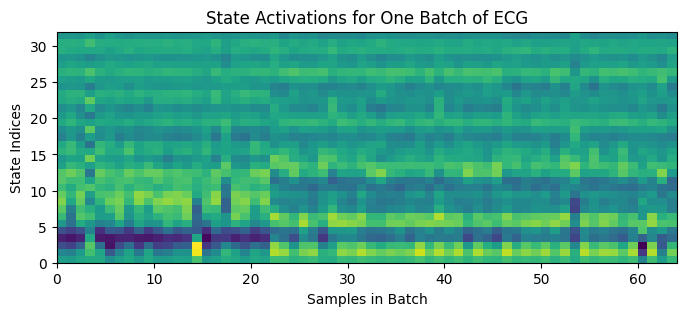

In [ ]:
batch_size = model.tau_theta
U_batch  = U_train[:batch_size]
y0_batch = y0_train[:batch_size]

X_batch = scan_ssm_batched_nomap(model.theta["A"], model.theta["B"], U_batch.T, model.x0)

ordered_states = np.concatenate([X_batch[y0_batch==0],X_batch[y0_batch==1]])
plt.figure(figsize=(8,3))
plt.pcolor(ordered_states.T)
plt.xlabel("Samples in Batch")
plt.ylabel("State Indices")
plt.title("State Activations for One Batch of ECG")
plt.show()

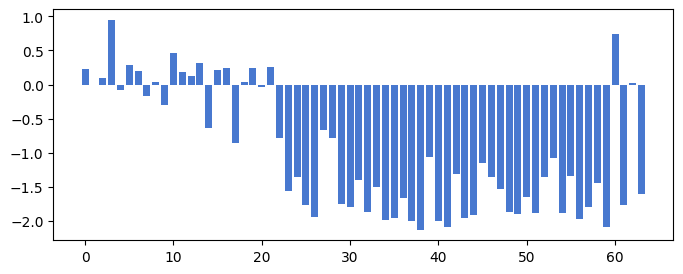

In [ ]:
y_batch = sf.forward_readout(X_batch, model.readout)

ordered_logits = np.concatenate([y_batch[y0_batch==0],y_batch[y0_batch==1]])

plt.figure(figsize=(8,3))
plt.bar(np.arange(batch_size),ordered_logits[:,0])
plt.show()

## MGD (just like before)

### 1. Forward pass

In [ ]:
cost0 = sf.loss_CE_binary(y0_batch,y_batch)
print(f"Ground cost on single batch = {cost0}")

Ground cost on single batch = 1.0454275608062744


### 2. Perturb

In [ ]:
perturbations = sf.get_perturbations(model.theta,model.epsilon,model.train_params,0)

theta_pert = copy.deepcopy(model.theta)

theta_pert = sf.apply_perturbations_to_params(model.theta,theta_pert,perturbations,model.train_params)

Perturbed cost on single batch = 1.045393943786621


### 3. Perturbed forward pass

In [ ]:

X_batch_P = sf.scan_ssm_batched_nomap(theta_pert["A"], theta_pert["B"], U_batch.T, model.x0)

y_batch_P = sf.forward_readout(X_batch_P, theta_pert["readout"])

costP = sf.loss_CE_binary(y0_batch,y_batch_P)

print(f"Perturbed cost on single batch = {costP}")

### 4. Collect Gradient

In [ ]:
delta_cost = costP-cost0
print(delta_cost)
grad_est = model.gradient
grad_est = sf.collect_grad(perturbations,delta_cost,model.eta0,grad_est)
hf.print_tree_sum(grad_est)

-3.361702e-05


### 5. Update!

In [ ]:
model.theta = jax.tree.map(lambda p, G: p - G/batch_size, model.theta, grad_est)

Difference in parameters

In [ ]:
hf.print_clean_tree(hf.tree_diff(model.theta0,model.theta))

: {'A': 0.005779098, 'B': 0.00018058787, 'readout': [{'biases': 0.00018058073, 'weights': 0.0057772007}, {'biases': 5.6431477e-06, 'weights': 0.0001805115}]}


## Full Training Loop

In [ ]:
@jax.jit
def input_to_cost(A, B0, readout, U, x0_mat, y0):
    return sf.loss_CE_binary(y0, sf.forward_readout(sf.scan_ssm_batched_nomap(A, B0, U.T, x0_mat), readout))

@jax.jit
def get_perturbations(theta,epsilon,pert_key):
    key = jax.random.PRNGKey(pert_key, impl=None)
    return jax.tree.map(
        lambda p: jax.random.choice(key, jnp.array([-1,1])*epsilon, shape=(p.shape)), theta
    )

@jax.jit
def apply_perturbations(theta,perturbations):
    return jax.tree.map(lambda param, pert: param+pert, theta, perturbations)

@jax.jit
def MGD_update(params,G):
    return jax.tree.map(
        lambda p, G: p - G, params, G
    )

@jax.jit
def one_perturbative_step(theta,epsilon,eta,pert_key,grad_est,U,x0,y0):

    perturbations = get_perturbations(theta,epsilon,pert_key)
    theta_pert    = apply_perturbations(theta,perturbations)

    c_0           = input_to_cost(theta["A"], theta["B"], theta["readout"], U, x0, y0)
    c_pert        = input_to_cost(theta_pert["A"], theta_pert["B"], theta_pert["readout"], U, x0, y0)
    
    delta_c       = c_pert - c_0

    grad_est      = sf.collect_grad(perturbations,delta_c,eta,grad_est)

    return grad_est, jnp.mean(c_0), pert_key+1

@jax.jit
def test_fn(theta,U,y0,x0):
    X = sf.scan_ssm_batched_nomap(theta["A"], theta["B"], U.T, x0)
    y = sf.forward_readout(X,theta["readout"])
    pred_class = (y[:,0] > 0.5).astype(jnp.int32)
    true_class = y0.astype(jnp.int32)
    return jnp.mean(pred_class == true_class)

In [ ]:
import optax
@jax.jit
def init_grad(params):
    return jax.tree.map(lambda p: jnp.zeros(shape=(p.shape)), params)

@jax.jit
def input_to_cost(A, B0, readout, U, x0_mat, y0):
    X      = sf.scan_ssm_batched_nomap(A, B0, U.T, x0_mat)
    logits = sf.forward_readout(X, readout)
    print(logits.shape)
    print(y0.shape)
    logits = logits.squeeze(-1)
    labels = y0.squeeze(-1)
    loss   =  optax.sigmoid_binary_cross_entropy(logits,labels).mean()
    # loss   = jnp.mean((y0_batch - logits) ** 2)
    return loss

@jax.jit
def get_perturbations(theta,epsilon,pert_key):
    key = jax.random.PRNGKey(pert_key, impl=None)
    return jax.tree.map(
        lambda p: jax.random.choice(key, jnp.array([-1,1])*epsilon, shape=(p.shape)), theta
    )

@jax.jit
def collect_grad(perts,delta_c,eta,G):
    return jax.tree.map(
        lambda G, p: G + p*delta_c*eta, G, perts
    )

@jax.jit
def apply_perturbations(theta,perturbations):
    return jax.tree.map(lambda param, pert: param+pert, theta, perturbations)

@jax.jit
def MGD_update(params,G):
    return jax.tree.map(
        lambda p, G: p - G, params, G
    )

@jax.jit
def one_perturbative_step(theta,epsilon,eta,pert_key,grad_est,U,x0,y0):
    # theta_pert=copy.deepcopy(theta)
    perturbations = get_perturbations(theta,epsilon,pert_key)
    theta_pert    = apply_perturbations(theta,perturbations)

    c_0           = input_to_cost(theta["A"], theta["B"], theta["readout"], U, x0, y0)
    c_pert        = input_to_cost(theta_pert["A"], theta_pert["B"], theta_pert["readout"], U, x0, y0)

    delta_c       = c_pert - c_0

    grad_est      = collect_grad(perturbations,delta_c,eta,grad_est)

    return grad_est, c_0, pert_key+1

@jax.jit
def test_fn(theta,U,y0,x0):
    X = sf.scan_ssm_batched_nomap(theta["A"], theta["B"], U.T, x0)
    y = jax.nn.sigmoid(sf.forward_readout(X,theta["readout"]))
    pred_class = (y[:,0] > 0.5).astype(jnp.int32)
    true_class = y0.astype(jnp.int32)
    return jnp.mean(pred_class == true_class)

Discretized HiPPO matrices for 140 time steps

 epoch | accuracy | cost | runtime 
 --------------------------------- 
(64, 1)
(64, 1)


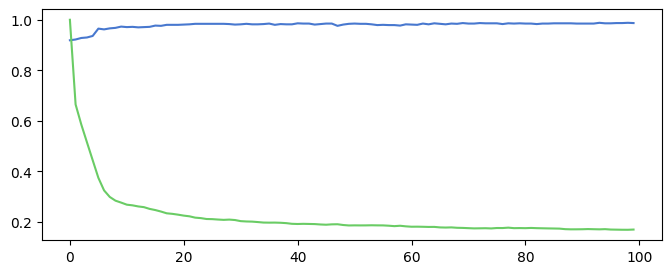

: {'A': 4.9758315, 'B': 0.22863644, 'readout': [{'biases': 0.22863665, 'weights': 4.9758244}, {'biases': 0.0021769444, 'weights': 0.22863463}]}


In [ ]:
np.random.seed(10)
model = SSM(
    N=32,
    train_params=["A","B","readout"],
    eta0="norm",
    epsilon=0.00001,
    tau_theta=64,
    readout_dims=[32,32,1],
    loss_func='CE',
    decay=0.01,
    )
print(model.eta0)
model.accs=[]
model.costs=[]
model.x0_test=jnp.zeros((y0_test.shape[0],model.N))

batch_size = model.tau_theta
epochs = 100
accs = []
costs = []
hf.print_header()
next_pert_key = 0

gradient=init_grad(model.theta)

# iterate over training epochs
for epoch in range(epochs):
    epoch_costs = []
    eta = sf.decay_rate(model.eta0,model.decay,epoch)

    #iterate over batchs
    for i in range(0, len(U_train)-batch_size, batch_size):
        
        # specify batched data
        U_batch  = U_train[i:i+batch_size]
        y0_batch = y0_train[i:i+batch_size]

        # forwared pass, perturbed forward pass, gradient estimation
        gradient, batch_cost, next_pert_key = one_perturbative_step(
            model.theta,
            model.epsilon,
            eta,
            next_pert_key,
            gradient,
            U_batch,
            model.x0,
            y0_batch[:,np.newaxis])
        
        # update parameters
        model.theta = MGD_update(model.theta,gradient)
        # hf.print_clean_tree(hf.tree_diff(model.theta,model.theta0))

        # reset gradient estimations
        gradient = init_grad(model.theta)

        # record batched training cost
        epoch_costs.append(batch_cost)

    # recored avg training cost
    model.costs.append(np.mean(epoch_costs))

    # test model accuracy on unseen data
    acc = test_fn(model.theta,U_test,y0_test,model.x0_test)
    model.accs.append(acc)
    # print(epochs,acc,model.costs[-1])
    hf.print_progress(epoch,model,'--',False,)

plt.figure(figsize=(8,3))
plt.plot(model.accs)
plt.plot(model.costs/np.max(model.costs))
plt.show()
hf.print_clean_tree(hf.tree_diff(model.theta,model.theta0))

C:\Users\rmo2\AppData\Local\Temp\1\ipykernel_43596\1489925144.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


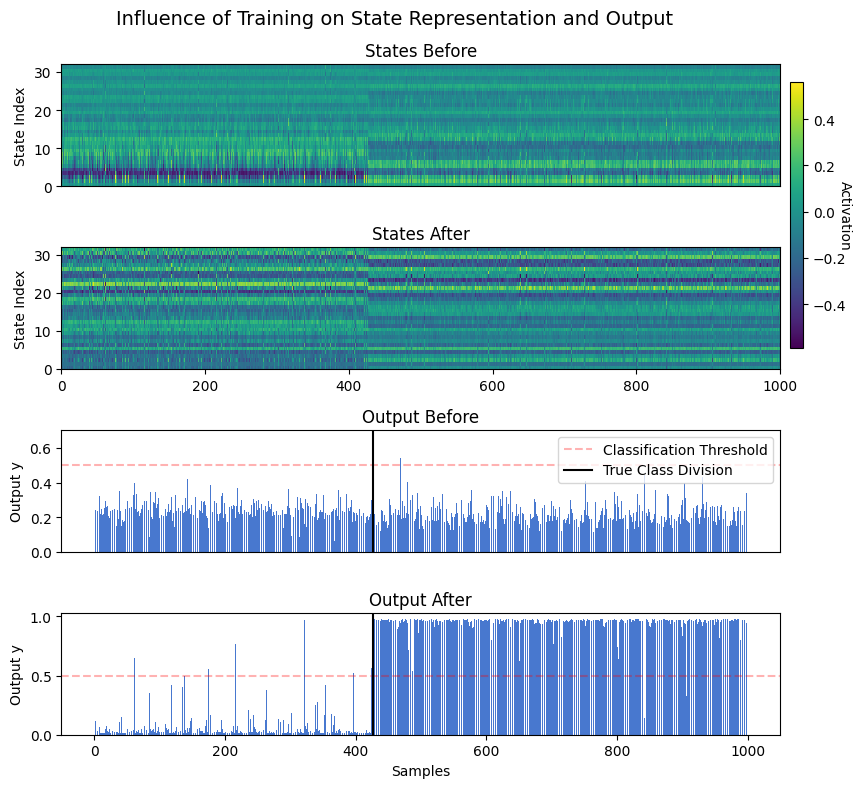

In [ ]:
batch_size = model.tau_theta
U_batch  = U_train[:batch_size]
y0_batch = y0_train[:batch_size]

def plot_before_and_after(model,U_batch,y_batch):
    X_batch_0 = sf.scan_ssm_batched_nomap(model.theta0["A"], model.theta0["B"], U_batch.T, model.x0_test)
    ordered_states_0 = np.concatenate([X_batch_0[y0_batch==0],X_batch_0[y0_batch==1]])

    X_batch = sf.scan_ssm_batched_nomap(model.theta["A"], model.theta["B"], U_batch.T, model.x0_test)
    ordered_states = np.concatenate([X_batch[y0_batch==0],X_batch[y0_batch==1]])

    y_batch_0 = jax.nn.sigmoid(sf.forward_readout(X_batch_0, model.theta0["readout"]))
    ordered_logits_0 = np.concatenate([y_batch_0[y0_batch==0],y_batch_0[y0_batch==1]])

    y_batch = jax.nn.sigmoid(sf.forward_readout(X_batch, model.readout))
    ordered_logits = np.concatenate([y_batch[y0_batch==0],y_batch[y0_batch==1]])

    plt.style.use('seaborn-v0_8-muted')
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    fig,ax = plt.subplots(4,1,figsize=(8,8))

    im1 = ax[0].pcolor(ordered_states_0.T)
    ax[1].pcolor(ordered_states.T)
    ax[0].set_title("States Before")
    ax[1].set_title("States After")
    ax[0].set_ylabel("State Index")
    ax[1].set_ylabel("State Index")
    ax[0].set_xticks([])

    cbar = fig.colorbar(im1, ax=[ax[0],ax[1]], location='right')
    cbar.set_label('Activation', rotation=270)
    pos = cbar.ax.get_position()
    new_pos = [pos.x0+.21, pos.y0 + 0.045, pos.width, pos.height * .9]  # move up + shrink height a bit
    cbar.ax.set_position(new_pos)

    bar_pre  = ax[2].bar(np.arange(len(ordered_logits_0)),ordered_logits_0[:,0])
    bar_post = ax[3].bar(np.arange(len(ordered_logits)),ordered_logits[:,0])

    ax[2].axhline(y=0.5,color='r', linestyle='--',alpha=0.3,label="Classification Threshold")
    ax[3].axhline(y=0.5,color='r', linestyle='--',alpha=0.3,label="Classification Threshold")

    ax[2].axvline(x=sum(y0_batch==0)-0.65*bar_pre[0].get_width(), color='k', label=f"True Class Division")
    ax[3].axvline(x=sum(y0_batch==0)-0.65*bar_pre[0].get_width(), color='k', label=f"True Class Division")

    ax[2].legend(loc="upper right")
    ax[2].set_title("Output Before")
    ax[3].set_title("Output After")
    ax[3].set_xlabel("Samples")
    ax[2].set_ylabel("Output y")
    ax[3].set_ylabel("Output y")
    ax[2].set_xticks([])
    plt.suptitle("Influence of Training on State Representation and Output",fontsize=14)
    plt.tight_layout()
    plt.show()

batch_size = model.tau_theta
U_batch  = U_test
y0_batch = y0_test

plot_before_and_after(model,U_batch,y_batch)